In [10]:
# https://pypi.org/project/isyatirimhisse/
# pip install isyatirimhisse==4.0.0
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
from datetime import datetime
from isyatirimhisse import StockData
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [11]:
# def download_stock_data(symbols, start_date='24-07-2020', exchange='0'):
#     stock_data = StockData()

#     data = stock_data.get_data(symbols=symbols, start_date=start_date, exchange=exchange)
#     data = data[['DATE', 'CLOSING_TL', 'CODE']]
#     data.to_excel(f'stockdata_{datetime.now().strftime("%Y%m%d")}.xlsx', index=False)

#     return data

#new
def download_stock_data(symbols, start_date='24-07-2020', days_to_fetch=500, exchange='0'):
    stock_data = StockData()

    # Convert start_date to datetime object
    start_datetime = datetime.strptime(start_date, '%d-%m-%Y')

    # Calculate end_date by adding days_to_fetch to start_date
    end_datetime = start_datetime + timedelta(days=days_to_fetch)
    end_date = end_datetime.strftime('%d-%m-%Y')

    # Fetch data for the specified time range
    data = stock_data.get_data(symbols=symbols, start_date=start_date, end_date=end_date, exchange=exchange)
    data = data[['DATE', 'CLOSING_TL', 'CODE']]
    data.to_excel(f'stockdata_{datetime.now().strftime("%Y%m%d")}.xlsx', index=False)

    return data



# Function to calculate portfolio statistics
def calculate_portfolio_statistics(log_returns, weights, days=252):
    portfolio_return = np.sum(log_returns.mean() * weights) * days
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(log_returns.cov() * days, weights)))
    portfolio_sharpe = portfolio_return / portfolio_volatility

    return portfolio_return, portfolio_volatility, portfolio_sharpe

# Function to optimize the portfolio using Monte Carlo simulation
def optimize_portfolio(log_returns, portfolio_n=10000, num_selected_stocks=7, days=252):
    np.random.seed(34)

    total_weights = np.zeros((portfolio_n, len(log_returns.columns)))
    returns = np.zeros(portfolio_n)
    volatility = np.zeros(portfolio_n)
    sharpe = np.zeros(portfolio_n)

    for pn in range(portfolio_n):
        selected_stocks_indices = np.random.choice(len(log_returns.columns), size=num_selected_stocks, replace=False)
        weights = np.zeros(len(log_returns.columns))
        weights[selected_stocks_indices] = np.random.random(num_selected_stocks)
        weights /= np.sum(weights)
        total_weights[pn, :] = weights

        returns[pn], volatility[pn], sharpe[pn] = calculate_portfolio_statistics(log_returns, weights, days)

    max_sharpe_index = sharpe.argmax()
    max_sharpe_weights = total_weights[max_sharpe_index, :]
    max_sharpe_return, max_sharpe_vol, max_sharpe = calculate_portfolio_statistics(log_returns, max_sharpe_weights, days)

    selected_stocks_indices = np.where(max_sharpe_weights > 0)[0]
    selected_stocks = log_returns.columns[selected_stocks_indices]
    selected_weights = max_sharpe_weights[selected_stocks_indices]

    return returns, volatility, sharpe, max_sharpe, selected_stocks, selected_weights, max_sharpe_return, max_sharpe_vol

Maximum Sharpe Ratio: 3.2658
Stocks and Weights of the Portfolio with Maximum Sharpe Ratio:
AKSEN: 17.06%
ENJSA: 17.90%
EREGL: 20.67%
GUBRF: 1.20%
OYAKC: 0.27%
SASA: 22.44%
TOASO: 20.45%
Return of the Portfolio with Maximum Sharpe Ratio: 87.14%
Volatility of the Portfolio with Maximum Sharpe Ratio: 26.68%


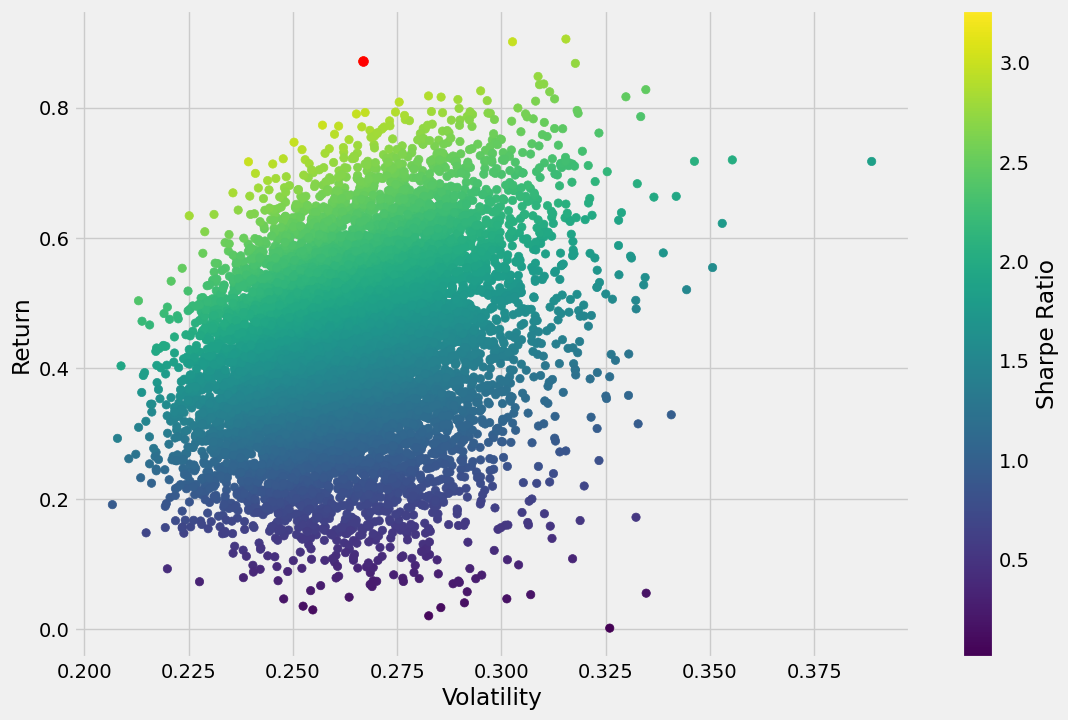

In [12]:
# https://www.kap.org.tr/tr/Endeksler
# Example usage: Fetch data for 500 days after '24-07-2020'

df = pd.read_excel('Sirketler.xlsx')

symbols = df['Kod'].tolist()
data = download_stock_data(symbols, start_date='24-07-2020', days_to_fetch=500)

# symbols = df['Kod'].tolist()
# data = download_stock_data(symbols)

data_pivot = data.pivot(index='DATE', columns='CODE', values='CLOSING_TL').dropna(axis=1)
log_returns = np.log(data_pivot / data_pivot.shift(1))

returns, volatility, sharpe, max_sharpe, selected_stocks, selected_weights, max_sharpe_return, max_sharpe_vol = optimize_portfolio(log_returns, days=252)

result = (
    f"Maximum Sharpe Ratio: {max_sharpe:.4f}\n"
    f"Stocks and Weights of the Portfolio with Maximum Sharpe Ratio:\n"
)

for stock, weight in zip(selected_stocks, selected_weights):
    result += f"{stock}: {weight * 100:.2f}%\n"

result += (
    f"Return of the Portfolio with Maximum Sharpe Ratio: {max_sharpe_return * 100:.2f}%\n"
    f"Volatility of the Portfolio with Maximum Sharpe Ratio: {max_sharpe_vol * 100:.2f}%"
)

print(result)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(volatility, returns, c=sharpe, cmap='viridis')
plt.colorbar(scatter, label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.scatter(max_sharpe_vol, max_sharpe_return, c='red', s=50)
plt.show()